# Decision Trees

Like SVMs, *Decision Trees* are versatile Machine Learning algorithms that can perform both classification and regression tasks, and even multioutput tasks. They are vecy powerful algorithms,capable of fitting complex datasets.

Decision Trees are also the fundamental components of Random Forests, which are among the most powerful Machine Learning algorithms available today.

In this chapter we start by discussing how to train, visualize, and make predictions with Decision Trees. Then we will go through the CART training algorithm used by Scikit-Learn, and we will discuss how to regularize trees and use them for regression tasks. Finally, we will discuss some of the limitations of Decision Trees.

## Training and Visualizing a Decision Tree

To understand Decision Trees, let's just uilkd one and take a look at how it makes predictions. The following code trains a DecisionTreeClassifier on the iris dataset:

In [3]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth = 2)
tree_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

You can visualize the trained Decision Tree by first using the export_graphviz() method to output a graph definition file called iris_tree.dot:

In [6]:
from sklearn.tree import export_graphviz

export_graphviz(
    tree_clf,
    out_file = "iris_tree.dot",
    feature_names = iris.feature_names[2:],
    class_names = iris.target_names,
    rounded = True,
    filled = True
)

Then you can convert this .dot file to a variety of formats sucha as PDF or PNG using the dot command-line tool from the graphviz package.

![alt text](tree.PNG "Decision Tree")

## Making Predictions

Let's see how the tree represented above makes predictions. Suppose you find an iris flower and you want to classify it. You start at the root node (depth 0, at the top): this node asks whether the flower's petal length is smaller than 2.45 cm. If it is, then you move down to the root's left child node (depth 1, left). In this case, it is a leaf node (i.e., it does not have any children nodes), so it does not ask any questions: you can simply look at the predicted class for that node and the Decision Tree predicts that your flower is an Iris-Setosa (class = setosa).

Now suppose you find another flower, but this time the petal length is greater than 2.45 cm. You must move down to the root's right child node (depth 1, right) which is not a leaf node, so it asks another question: is the petal width smaller than 1.75 cm? If it is, then your flower is most likely an Iris-Versicolor (depth 2, left), if not, it is likely an Iris-Virginica (depth 2, right). It's really that simple.

**Note**:

One of the many qualities of Decision Trees is that they require very little data preparation. In particular, they don't require feature scaling or centering at all.

A node's samples attribute counts how many training instances it applies to. For example, 100 training instances have a petal length greater than 2.45 cm (depth 1, right), among which 54 have a petal width smaller than 1.75 cm (detph 2, left). A node's value attribute tells you how many training instances of each class this node applies to: for example, the bottom right node applies to 0 Iris-Setosa, 1 Iris-Versicolor, and 45 Iris-Virginica. 

Finally, a node's gini attribute measures its impurity: a node is "pure" (gini = 0) if all training instances it applies to belong to the same class. For example, since the depth-1 left node applies only to Iris-Setosa training instances, it is pure and it's gini score i s 0. 

The equation below shows how the training algorithm computes the gini score $G_i$ of the $i^{th}$ node. For example, the depth-2 left node has a gini score equal to $1 - (0/54)^2 - (49/54)^2 - (5/54)^2 \approx 0.168$. Another impurity measure is discussed shortly.

$$ G_i = 1 - \sum_{k = 1}^n p_{i,k}^2$$

- $p_{i,k}$ is the ratio of class k instances among the training instances in the $i^{th}$ node.

**Node**:

Scikit-Learn uses the CART algorithm, which produces only *binary trees*: nonleaf nodes always have two children (i.e: questions only have yes/no answers). However, other algorithms such as ID3 can produce Decision Trees with nodes that have more than two children.

## Model Interpretation: White Box Versus Black Box

As you can see Decision Trees are fairly intuitive and their decisions are easy to interpret. Such models are often called *white box models*. In contrast, as we will see, Random Forests or neural networks are generally considered *black box models*. They make great predictions, and you can easily check the calculations that they performed to make these predictions; nevertheless, it is usually hard to explain in simple terms whi the predictions were made. For example, if a neural network says that a particular person appears on a picture, it is hard to know what actually contributed to this prediction: did the model recognize that person's eyes? Her mouth? Her nose? Her shoes? Or even the couch that she was sitting on? Conversely, Decision Trees provide nice and simple classification rules that can even be applied manually if need be (e.g. for flower classification).

## Estimating Class Probabilities

A Decision Tree can also estimate the probability that an instance belongs to a particular class k: first it traverses the tree to find the leaf node for this instance, and then it returns the ratio of training instances of class k in this node. For example, suppose you have found a flower whose petals are 5 cm long and 1.5 cm wide. The corresponsing leaf node is the depth-2 leaf node, so the Decision Tree should output the following probabilities: 0% for Iris-Setosa (0/54), 90.7% for Iris-Versicolor (49/54), and 9.3% for Iris-Virginica (5/54). And of course if you ask it to predict the class, it should output Iris-Versicolor (class 1) since it has the highest probability. Let's check it:

In [9]:
print(tree_clf.predict_proba([[5,1.5]]))
print(tree_clf.predict([[5, 1.5]]))

[[0.         0.90740741 0.09259259]]
[1]


## The CART Training Algorithm

Scikit-Learn uses the *Classification And Regression Tree* (CART) algorithm to train Decision Trees (also called "growing" trees). The idea is really quiite simple: the algorithm first splits the training set in two subsets using a single feature k and a threshold $t_k$ (e.g. p"etal length $\leq$ 2.45 cm").

How does it choose k and $t_k$? It searches for the pair (k, $t_k$) that produces the purest subsets (weighted by their size). THe cost function that the algorithm tries to minimize is given by the equation below:

$$ J(k, t_k) = \frac{m_{left}}{m}G_{left} + \frac{m_{right}}{m}G_{right}$$

where:

$G_{left/right}$ measures the impurity of the left/right subset,
$m_{left/right}$ measures the number of instances in the left/right subset.

Once it has successfully split the training set in two, it splits the subsets using the same logic, then the sub-subsets and so on, recursively. It stops recursing once it reaches the maximum depth (defined by the max_depth hyperparameter), or if it cannot find a split that will reduce impurity. A few other hyperparamethers (describes in a moment) control additional stopping conditions (min_samples_split, min_samples_leaf, min_weight_francion_leaf, and max_leaf_nodes).

**Caution**:

As you can see, the CART algorithm is a *greedy algorithm*: it greedily searches for an optimum split at the top level, then repeats the process at each level. It does not check whether or not the split will lead to the lowest possible impurity several levels down. A greedy algorithm often produces a reasonably good solution, but it is not guaranteed to be the optimal solution.

Unfortunately, finding the optimal tree is known to be an *NP-Complete problem*: it requires O(exp(m)) time, making the problem intractable even for fairly small training sets. This is why we must settle for a "reasonably good" solution.

## Computational Complexity

Making predictions requires traversing the Decision Trees from the root to a leaf. DT are generally approximately balanced, so traversing the Decision Tree requires going through roughly O($log_2$(m)) nodes. Since each node only requires checking the value of one feature, the overall prediction complexity is just O($log_2$(m)), independent of the number of features. So predictions are very fast, even when dealing with large training sets.

However, the training algorithm compares all features (or less if max_features is set) on all samples at each node. This results in a training complexity of O(n x m log(m)). For small training sets (less than a few thousand instances), Scikit-Learn can speed up training by presorting the data (set presort = True), but this slows down training considerably for larger training sets.

## Gini Impurity or Entropy?

By default, the Gini impurity measure is used, but you can select the *entropy* impurity measure instead by setting the criterion hyperparameter to "entropy". The concept of entropy originated in thermodynamics as a measure of molecular disorder: entropy approaches zero when molecules are still and well ordered. It later spread to a wide variety of domains, including Shannon's *information theory*, where it measures the average information content of a message: entropy is zero when all messages are identical. In Machine Learning, it is frequently used as an impurity measure: a set's entropy is zero when it contains instances of only one class. The equation below shows the definition of the entropy of the $i^{th}$ node. For example, the depth-2 left node in the figure has an entropy equal to $\frac{49}{54}log_2(\frac{49}{54}) - \frac{5}{54}log_2(\frac{5}{54}) \approx 0.445$.

$$\sum_{\substack{k = 1 \\ p_{i,k} \neq 0}}^n p_{i,k} log_2(p_{i,k})$$

So should you use Gini impurity or entropy? The truth is, most of the time it does not make a big difference: they lead to similar trees, Gini impurity is slightly faster to compute, so it is a good default. However, when they differ, Gini impurity tends to isolate the most frequent class in its own branch of the tree, while entropy tends to produce slighly more balanceed trees.

## Regularization Hyperparameters

Decision Trees make very few assumptions about hte training data (as opposed to linear models, which obviously assume that the data is linear, for example). If left unconstrained, the tree structure will adapt itself to the training data, fitting it very closely, and most likely overfitting it. Such a model is often called a *nonparametric model*, not because it does not have any parameters (it often has a lot) but because the number of parameters is not determined prior to training, so the model structure is free to stick closely to the data. In constrast, a *parametric model* such as a linear model has a predetermined number of parameters, so its degree of freedom is limited, reducing the risk of overfitting (but increasing the risk of underfitting).

To avoid overfitting the training data, you need to restrict the Decision Tree's freedom during training. As you know by now, this is called regularization. The regularization hyperparameters depend on the algorithm used, but generally you can at least restrict the maximum depth of the Decsion tree. In Scikit-Learn, this is controlled by the max_depth hyperparameter (the default value is None, which means unlimited). Reducing max_depth will regularize the model and thus reduce the risk of overfitting.

The DecisionTreeClassifier class has a few other parameters that similarly restrict the shape of the Decision Tree: min_samples_split (the minimum number of samples a node must have before it can be split), min_samples_leaf (the minimum number of samples a leaf node must have), min_weight_fraction_leaf (same as min_samples_leaf but expressed as a fractrion of the total number of weighted instances), max_leaf_nodes (maximum number of leaf nodes), and max_features (maximum number of features that are evaluated for splitting each node). Increasing min_* hyper parameters or reducing max_* hyperparameters will regularize the model.

**Note**:

Other algorithms work by first training the Decision Tree without restrictions, then *pruning* (deleting) unnecessary nodes. A node whose children are all leaf nodes is considered unnecessary if the purity improvement it provides is not *statistically significant*. Standard statistical tests, such as the $\chi^2$ test, are used to estimate the probability that the improvement is purely the result of chance (which is called the *null hypothesis*). If this probability, called the *p-value*, is higher than a given threshold (typically 5%, controlled by an hyperparameter), then the node is considered unnecessary and its children are deleted. The pruning continues until all unnecessary nodes have been pruned. 

## Regression

Decision Trees are also capable of performing regression tasks. Let's build a regression tree using Scikit-Learn's DecisionTreeRegressor class, training it on a noisy quadratic dataset with max_depth = 2:

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth = 2)
tree_reg.fit(X, y)

The resulting tree is represented in the figure below:

![alt text](tree2.PNG "Decision Tree")

The tree looks very similar to the classification tree you built earlier. The main difference is that instead of predicting a class in each node, it predicts a value. For example, suppose you want to make a prediction for a new instance with $x_1$ = 0.6. You traverse the tree starting at the root, and eventually reach the leaf node that predicts value = 0.1106. This prediction is simply the average target value of the 110 training instances associated to this leaf node. This prediction results in a Mean Squared Error (MSE) equal to 0.0151 over these 110 instances.

The CART algorithm works mostly the same way as earlier, except that instead of trying to split the training set in a way that minimizes impurity, it now tries to split the training set in a way that minimizes the MSE. The equation below shows the cost function that the algorithm tries to minimize.

$$ J(k, t_k) = \frac{m_{left}}{m}MSE_{left} + \frac{m_{right}}{m}MSE_{right}$$

where:

$MSE_{node} = \sum_{i \in node} (\hat{y}_{node} - y^{(i)})^2$

$\hat{y}_{node} = \frac{1}{m_{node}} \sum_{i \in node}y^{(i)}$

Just like for classification tasks, Decision Trees are prone to overfitting when dealing with regression tasks. 

## Instability

Hopefully by now you are convinced that Decision Trees have a lot going for them: they are simple to understand and interpret, easy to use, versatile, and powerful. However, they do have a few limitations. First, Decision Trees love orthogonal decision boundaries (all splits are perpendicular to an axis), which makes them sensitive to training set rotation. For example, the figure below shows a simple linarly separable dataset: on the left, a Decision Tree can split it easily, while on the right, after the dataset is rotated by 45 degrees, the decision boundary looks unnecessarily convoluted. Altough both Decision Trees fit the training set perfectly, it is very likely that the model on the right will not generalize well. One way to limit this problem is to use PCA, which often results in a better orientation of the training data.

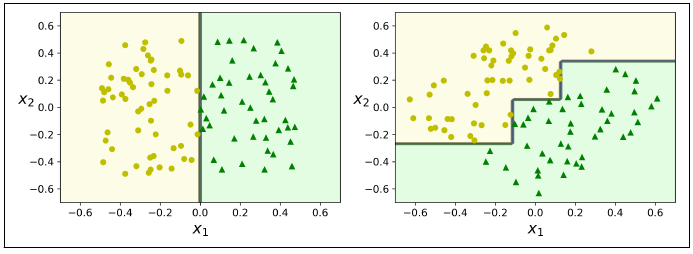

More generally, the main issue with Decision Trees is that they are very sensitive to small variations in the training data. Actually, since the training algorithm used by Scikit-Learn is stochastic you may get very different models even on the same training data (unles you set the random_state hyperparameter).

Random forest can limit this instability by averaging predictions over many trees as we will see in the next chapter.